# Equipe :
*   Eduardo Fontes Baltazar da Silveira
*   André Neves da Rocha Castro
*   João Pedro Lima Ribeiro



Foi escolhido o dataset "gym-members-exercise-dataset" disponível no Kaggle.
O objetivo do modelo será prever o número de calorias queimadas com base em diversos dados,como peso,altura,frequência etc.
Logo se trata de uma tarefa de regressão.

# Sumário

1.   Configurações de ambiente
2.   Carregamento do Dataset
3.   Análise e Tratamento do Dataset
4.   Treinamento e Validação Cruzada para diferentes números de neurônios
5.   Análise dos resultados obtidos no item 4
6.   Treinamento do modelo com número de neurônios que obtiveram melhor avaliação e aplicando diferentes learning rates e batch sizes
7.   Análise dos resultados obtidos no item 6
8.   Treinamento do modelo com número de neurônios que obtiveram melhor avaliação e aplicando diferentes modelos de otimização
9.    Análise dos resultados




# Configurações de ambiente

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
# Configuração de semente para reprodutibilidade
np.random.seed(42)
torch.manual_seed(42)


# Carregamento do Dataset

In [2]:
path = kagglehub.dataset_download("valakhorasani/gym-members-exercise-dataset")
print("Path to dataset files:", path)

100%|██████████| 21.6k/21.6k [00:00<00:00, 32.7MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/valakhorasani/gym-members-exercise-dataset/versions/1


In [3]:
import os

# Diretório do dataset
dataset_dir = "/root/.cache/kagglehub/datasets/valakhorasani/gym-members-exercise-dataset/versions/1"

# Listar arquivos
arquivos = os.listdir(dataset_dir)
print("Arquivos no dataset:", arquivos)


Arquivos no dataset: ['gym_members_exercise_tracking.csv']


In [4]:
caminho_csv = os.path.join(dataset_dir, "gym_members_exercise_tracking.csv")
dataset = pd.read_csv(caminho_csv)

# Análise e Tratamento do Dataset

In [5]:
dataset_encoded = pd.get_dummies(dataset, drop_first=True) #Converter colunas categóricas em numéricas (one-hot encoding)

In [6]:
target = 'Calories_Burned'
X = dataset_encoded.drop(columns=[target])
y = dataset_encoded[target]

In [7]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            973 non-null    int64  
 1   Gender                         973 non-null    object 
 2   Weight (kg)                    973 non-null    float64
 3   Height (m)                     973 non-null    float64
 4   Max_BPM                        973 non-null    int64  
 5   Avg_BPM                        973 non-null    int64  
 6   Resting_BPM                    973 non-null    int64  
 7   Session_Duration (hours)       973 non-null    float64
 8   Calories_Burned                973 non-null    float64
 9   Workout_Type                   973 non-null    object 
 10  Fat_Percentage                 973 non-null    float64
 11  Water_Intake (liters)          973 non-null    float64
 12  Workout_Frequency (days/week)  973 non-null    int

In [8]:
print(dataset.describe())

              Age  Weight (kg)  Height (m)     Max_BPM     Avg_BPM  \
count  973.000000   973.000000   973.00000  973.000000  973.000000   
mean    38.683453    73.854676     1.72258  179.883864  143.766701   
std     12.180928    21.207500     0.12772   11.525686   14.345101   
min     18.000000    40.000000     1.50000  160.000000  120.000000   
25%     28.000000    58.100000     1.62000  170.000000  131.000000   
50%     40.000000    70.000000     1.71000  180.000000  143.000000   
75%     49.000000    86.000000     1.80000  190.000000  156.000000   
max     59.000000   129.900000     2.00000  199.000000  169.000000   

       Resting_BPM  Session_Duration (hours)  Calories_Burned  Fat_Percentage  \
count   973.000000                973.000000       973.000000      973.000000   
mean     62.223022                  1.256423       905.422405       24.976773   
std       7.327060                  0.343033       272.641516        6.259419   
min      50.000000                  0.500000 

Análise gráfica


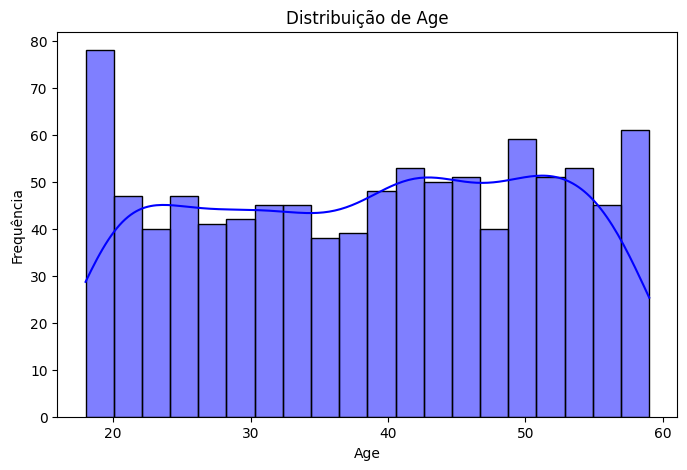

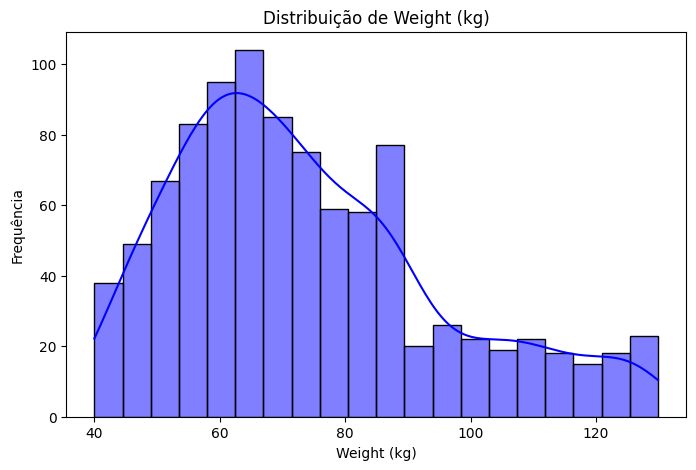

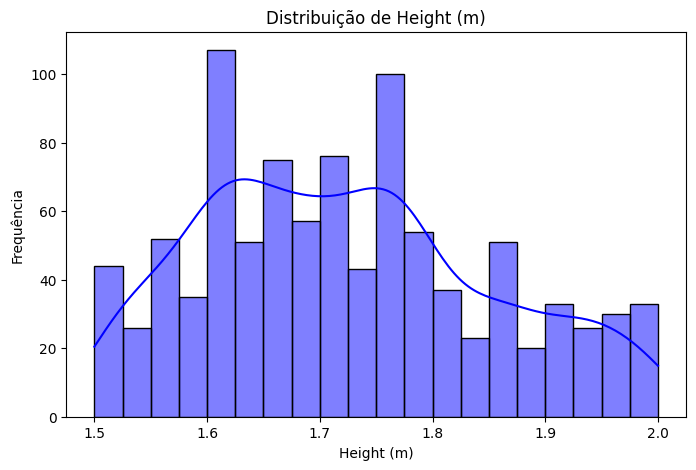

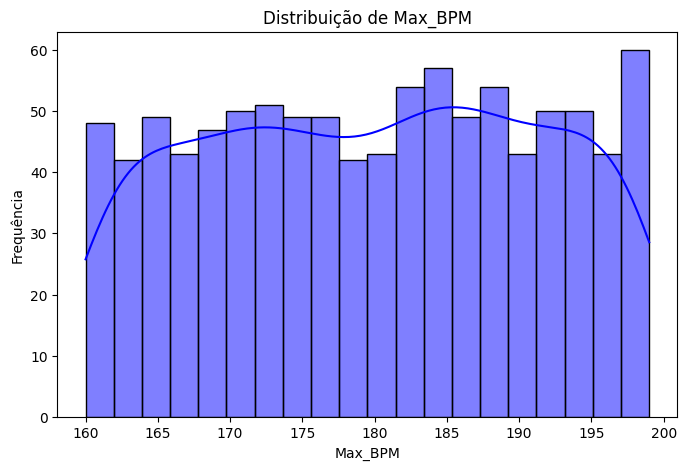

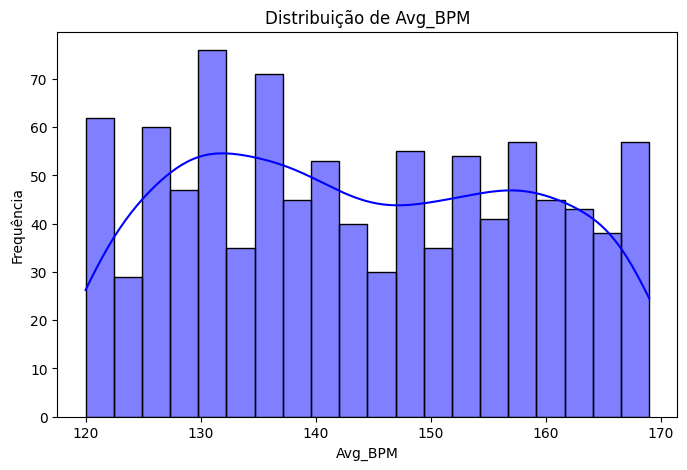

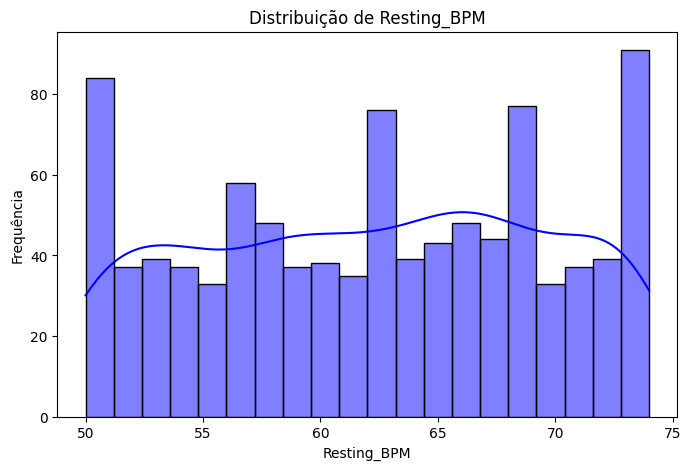

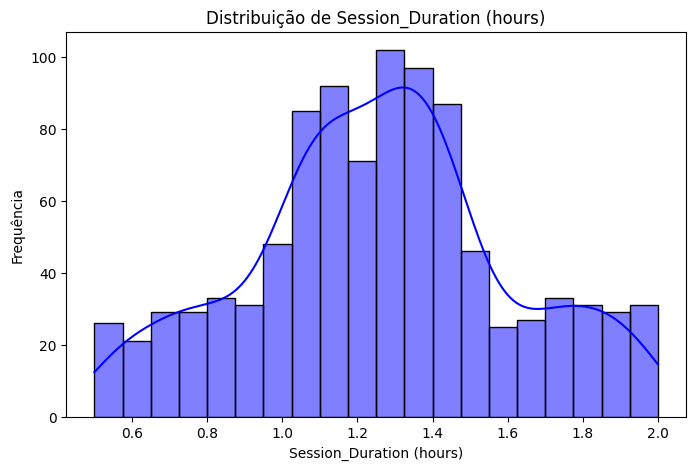

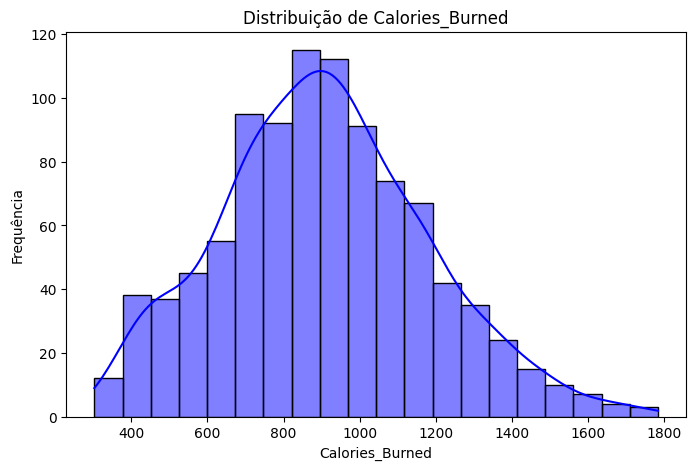

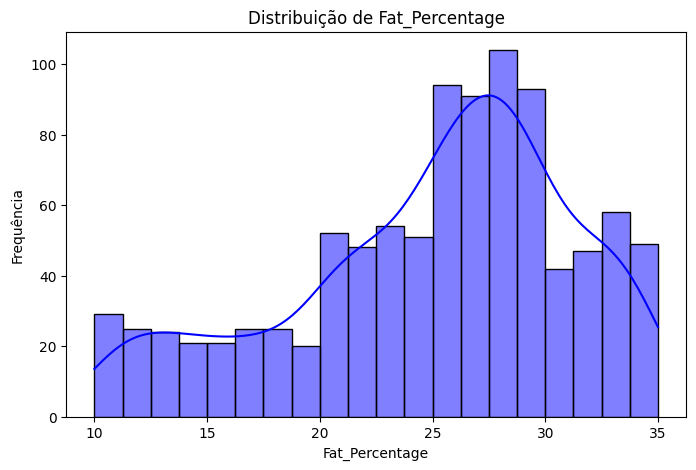

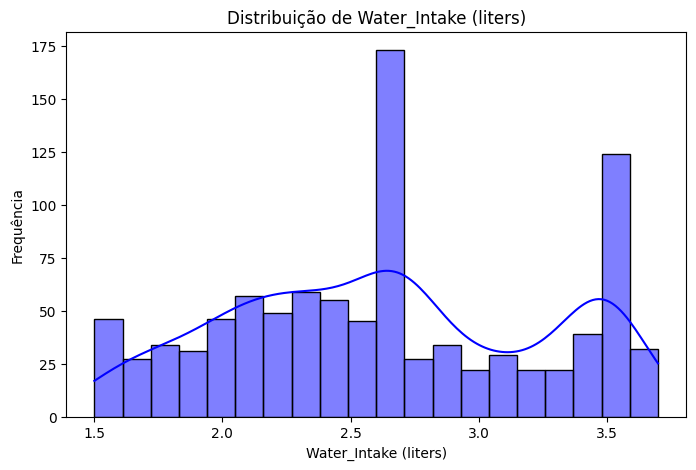

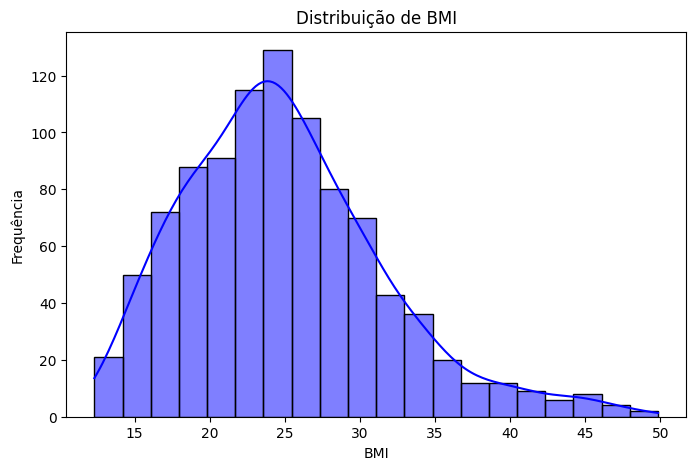

In [9]:
colunas_continuas = [
    'Age', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM',
    'Session_Duration (hours)', 'Calories_Burned', 'Fat_Percentage',
    'Water_Intake (liters)', 'BMI'
]

for coluna in colunas_continuas:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=dataset, x=coluna, kde=True, bins=20, color='blue')
    plt.title(f'Distribuição de {coluna}')
    plt.xlabel(coluna)
    plt.ylabel('Frequência')
    plt.show()

<ipython-input-10-a2306a2d4dd7>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=dataset, x=coluna, palette='viridis')


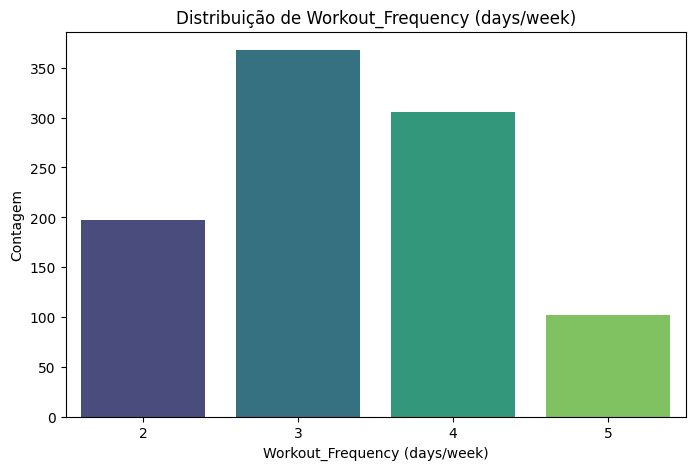

<ipython-input-10-a2306a2d4dd7>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=dataset, x=coluna, palette='viridis')


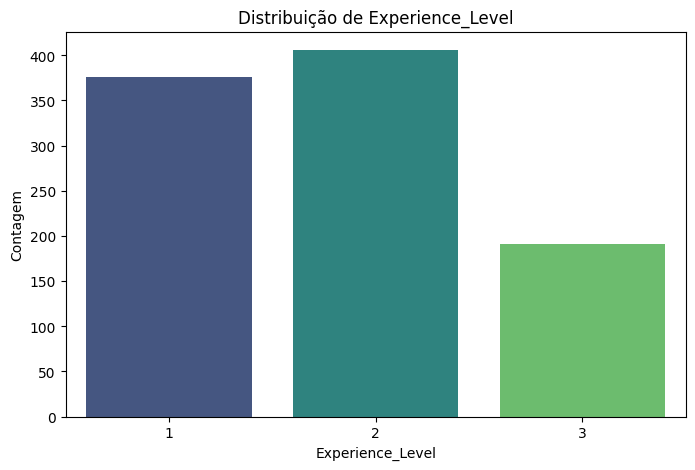

In [10]:
colunas_discretas = ['Workout_Frequency (days/week)', 'Experience_Level']

for coluna in colunas_discretas:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=dataset, x=coluna, palette='viridis')
    plt.title(f'Distribuição de {coluna}')
    plt.xlabel(coluna)
    plt.ylabel('Contagem')
    plt.show()


Análise e tratamento de correlações

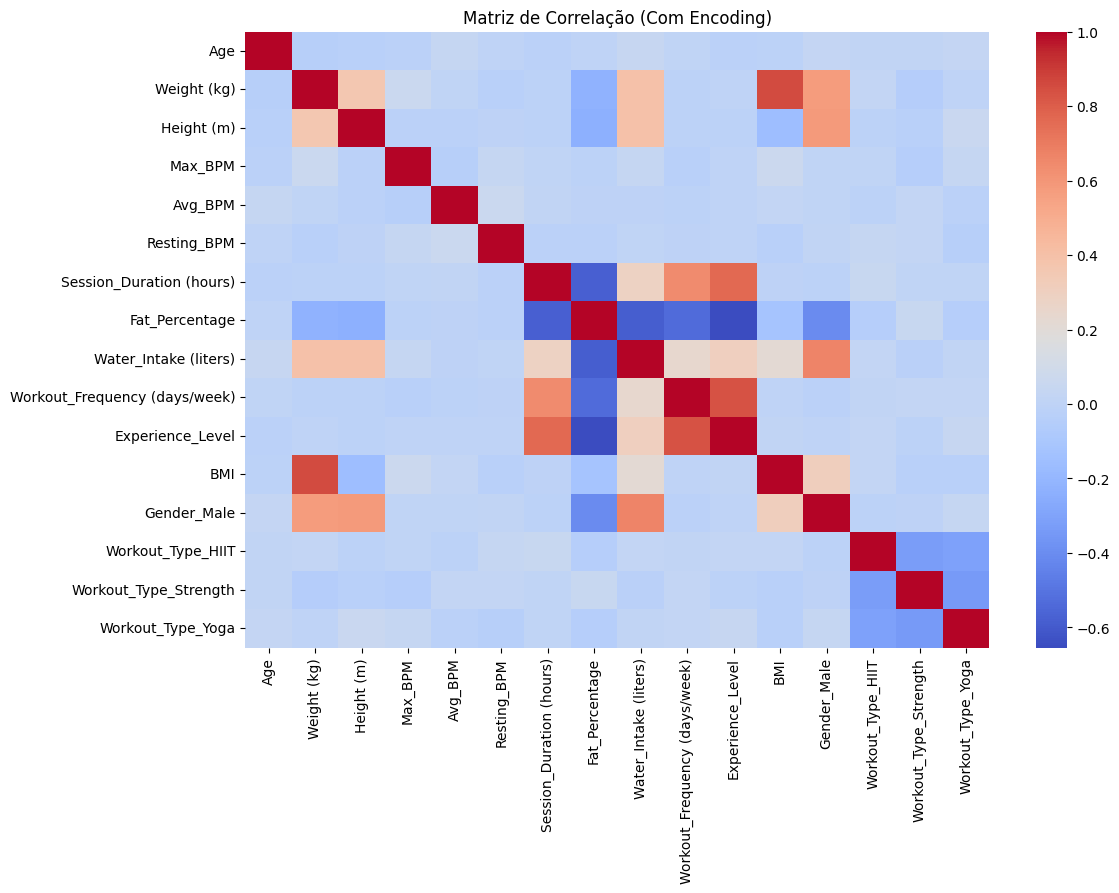

In [11]:
correlacao = X.corr()
# Plotar o heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlacao, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação (Com Encoding)')
plt.show()

In [12]:
threshold = 0.8
correlacoes_fortes = [
    (col1, col2) for col1 in correlacao.columns for col2 in correlacao.columns
    if col1 != col2 and abs(correlacao.loc[col1, col2]) > threshold
]

print("Pares altamente correlacionados:")
print(correlacoes_fortes)
variaveis_para_remover = set()
for col1, col2 in correlacoes_fortes:
    if col1 not in variaveis_para_remover:
        variaveis_para_remover.add(col2)
X = X.drop(columns=variaveis_para_remover)
print(f"Variáveis removidas: {variaveis_para_remover}")

Pares altamente correlacionados:
[('Weight (kg)', 'BMI'), ('Workout_Frequency (days/week)', 'Experience_Level'), ('Experience_Level', 'Workout_Frequency (days/week)'), ('BMI', 'Weight (kg)')]
Variáveis removidas: {'Experience_Level', 'BMI'}


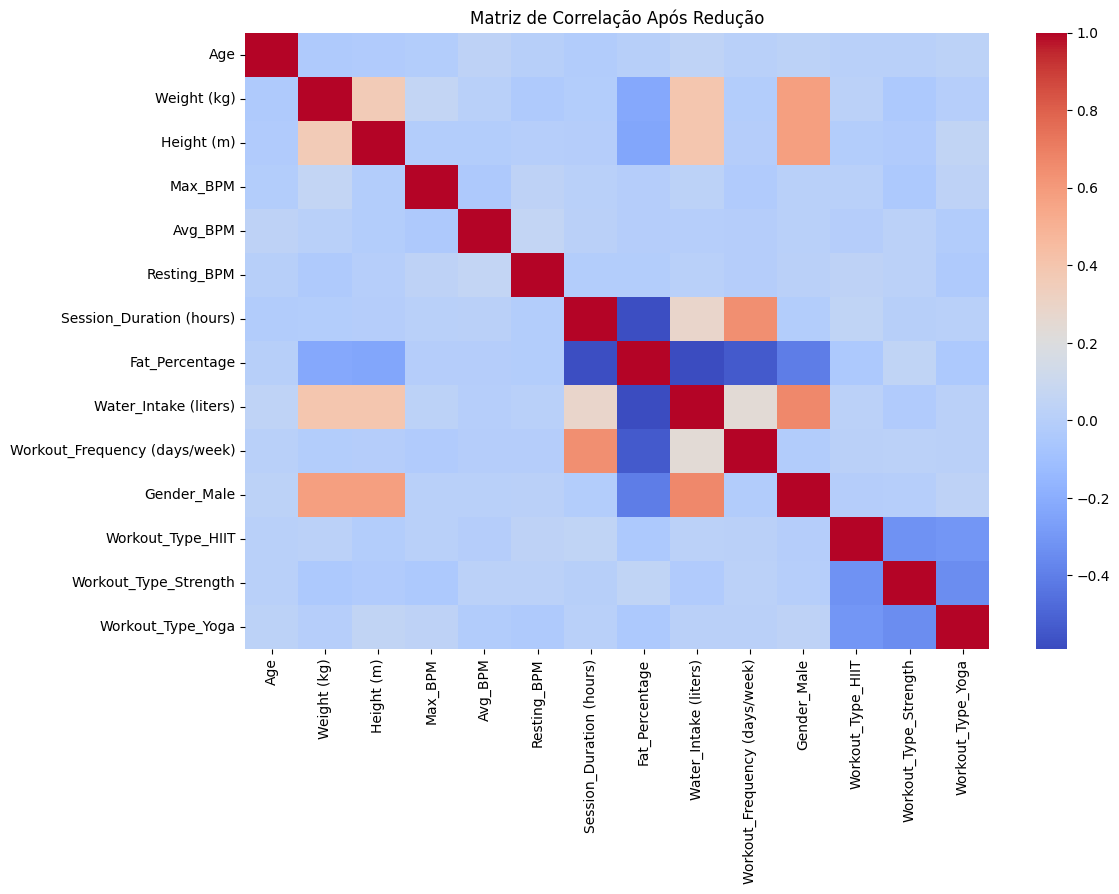

In [13]:
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação Após Redução')
plt.show()

# Pré-Processamento

In [14]:
# Pré-processamento
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Divisão treino/validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Conversão para tensores do PyTorch
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)

# Treinamento e Validação Cruzada para diferentes números de neurônios

Rede Neural Rasa

In [15]:
# Definição do modelo MLP (uma camada oculta)
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_neurons):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_neurons)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_neurons, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)


Treinamento e Validação Cruzada

In [16]:
def train_with_kfold(
    X, y, hidden_neurons_list, epochs=100, batch_size=32, k=5, initializations=5
):
    """
    Treinamento com validação cruzada e múltiplas inicializações
    """
    results = []
    criterion = nn.MSELoss()

    # Garantir que os dados já estão no formato de tensores PyTorch
    dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X), torch.FloatTensor(y))

    for hidden_neurons in hidden_neurons_list:
        all_mse_scores = []  # Armazena os MSEs de todas as inicializações

        for init in range(initializations):
            # Configurar uma semente aleatória para cada inicialização
            torch.manual_seed(init)

            mse_scores = []  # Armazena os MSEs por fold
            histories = []  # Armazena as curvas de treinamento para plotagem

            kf = KFold(n_splits=k, shuffle=True, random_state=42)
            for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
                train_data = torch.utils.data.Subset(dataset, train_idx)
                val_data = torch.utils.data.Subset(dataset, val_idx)

                train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
                val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

                model = MLP(X.shape[1], hidden_neurons)
                optimizer = optim.SGD(model.parameters(), lr=0.01)

                train_losses = []
                val_losses = []

                for epoch in range(epochs):
                    # Treinamento
                    model.train()
                    train_loss_epoch = 0
                    for X_batch, y_batch in train_loader:
                        optimizer.zero_grad()
                        y_pred = model(X_batch)
                        loss = criterion(y_pred, y_batch)
                        loss.backward()
                        optimizer.step()
                        train_loss_epoch += loss.item()
                    train_losses.append(train_loss_epoch / len(train_loader))

                    # Validação
                    model.eval()
                    val_loss_epoch = 0
                    with torch.no_grad():
                        for X_batch, y_batch in val_loader:
                            y_pred = model(X_batch)
                            loss = criterion(y_pred, y_batch)
                            val_loss_epoch += loss.item()
                    val_losses.append(val_loss_epoch / len(val_loader))

                # Salvar histórico do fold
                histories.append({'train_loss': train_losses, 'val_loss': val_losses})

                # Reverter escala das previsões para cálculo do MSE
                val_preds = []
                val_targets = []
                with torch.no_grad():
                    for X_batch, y_batch in val_loader:
                        y_pred = model(X_batch)
                        val_preds.append(y_pred)
                        val_targets.append(y_batch)

                val_preds = torch.cat(val_preds).numpy()
                val_targets = torch.cat(val_targets).numpy()

                # Calcular MSE diretamente
                val_mse = mean_squared_error(val_targets, val_preds)
                mse_scores.append(val_mse)

            # Adicionar os MSEs de cada fold para esta inicialização
            all_mse_scores.extend(mse_scores)

            # Plotar curvas de treinamento para cada fold
            plt.figure(figsize=(10, 6))
            for i, history in enumerate(histories):
                plt.plot(history['train_loss'], label=f"Treino - Fold {i+1}", alpha=0.7)
                plt.plot(history['val_loss'], label=f"Validação - Fold {i+1}", linestyle='dashed', alpha=0.7)
            plt.title(f"Curvas de Treinamento ({hidden_neurons} Neurônios, Inicialização {init + 1})")
            plt.xlabel("Épocas")
            plt.ylabel("Loss (MSE)")
            plt.legend()
            plt.grid()
            plt.show()

        # Resultados médios e desvio padrão para esta configuração de neurônios
        results.append({
            'hidden_neurons': hidden_neurons,
            'mean_mse': np.mean(all_mse_scores),
            'std_mse': np.std(all_mse_scores)
        })

    # Resultados consolidados
    for res in results:
        print(f"Neurônios: {res['hidden_neurons']}, MSE Médio: {res['mean_mse']:.4f}, "
              f"Desvio Padrão: {res['std_mse']:.4f}")

    return results


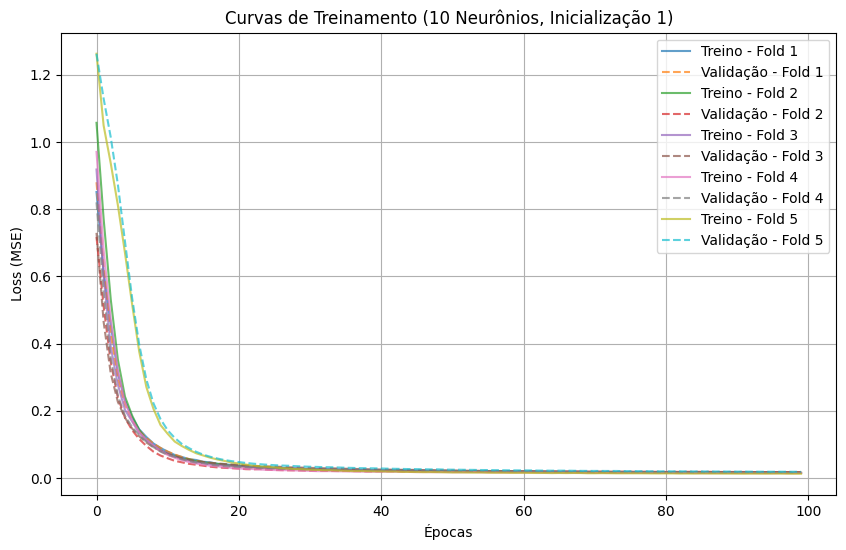

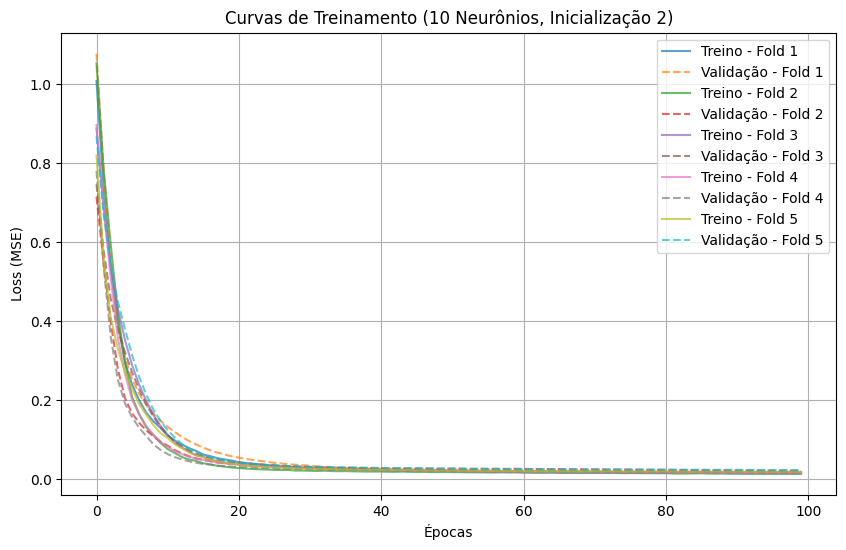

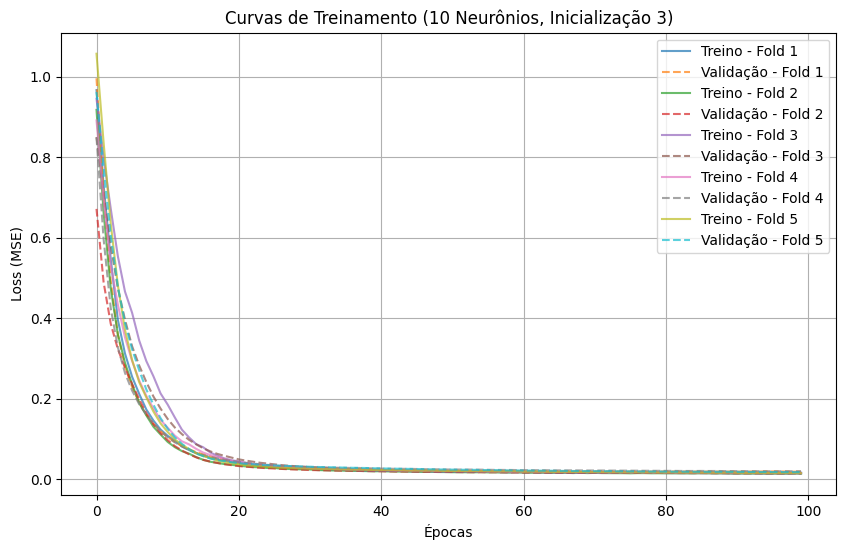

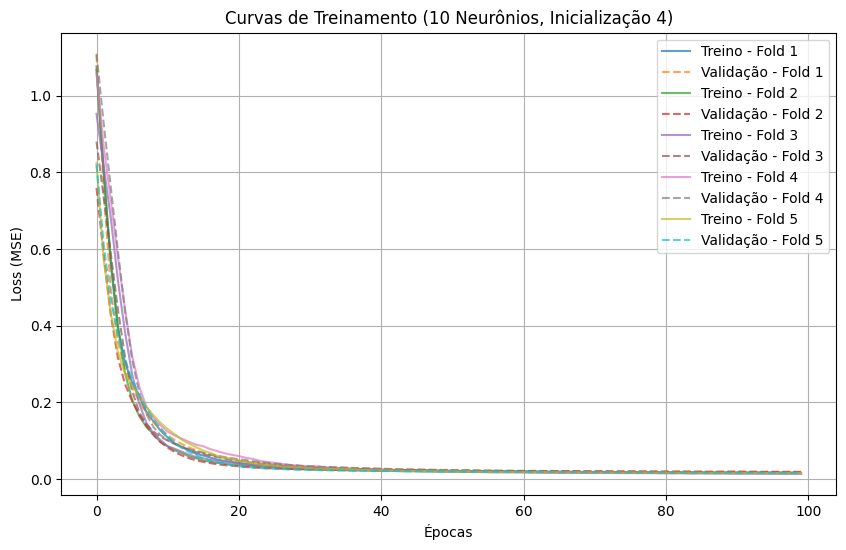

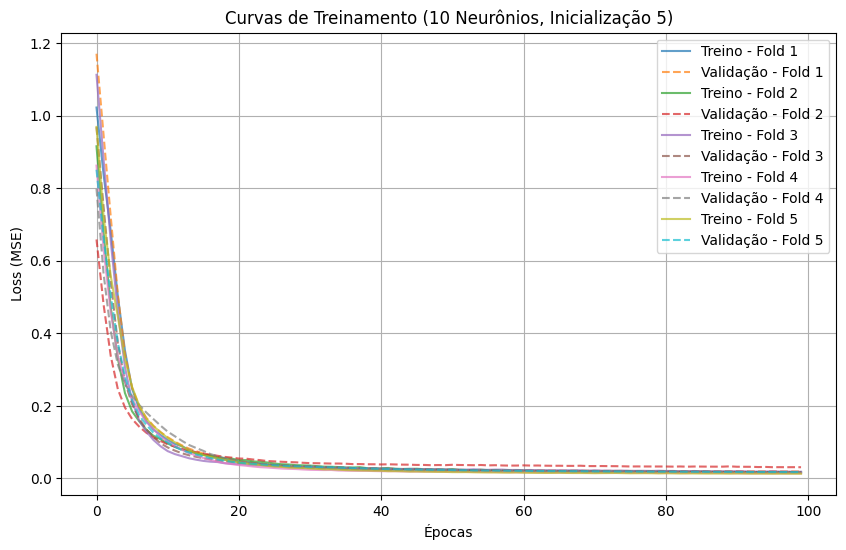

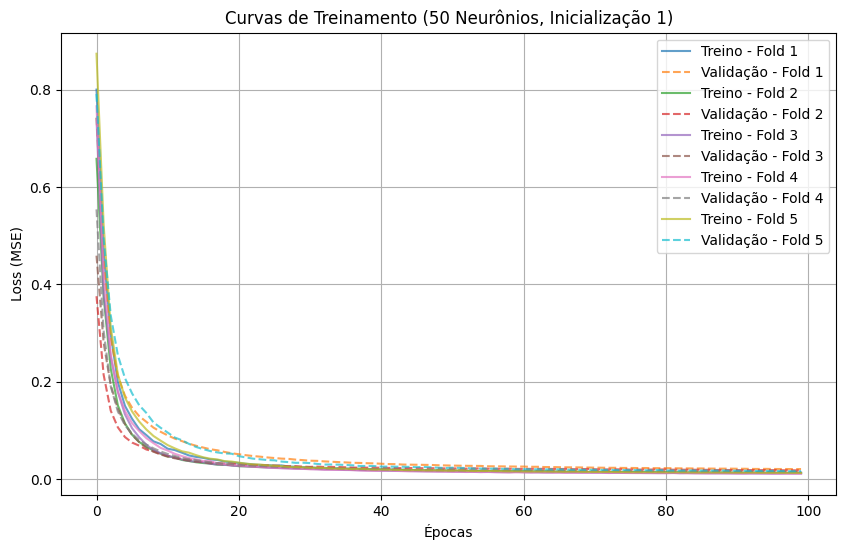

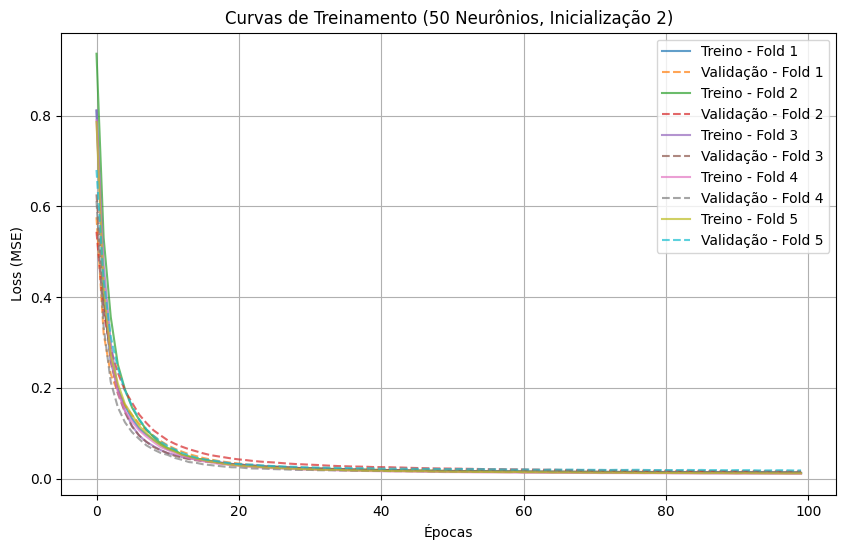

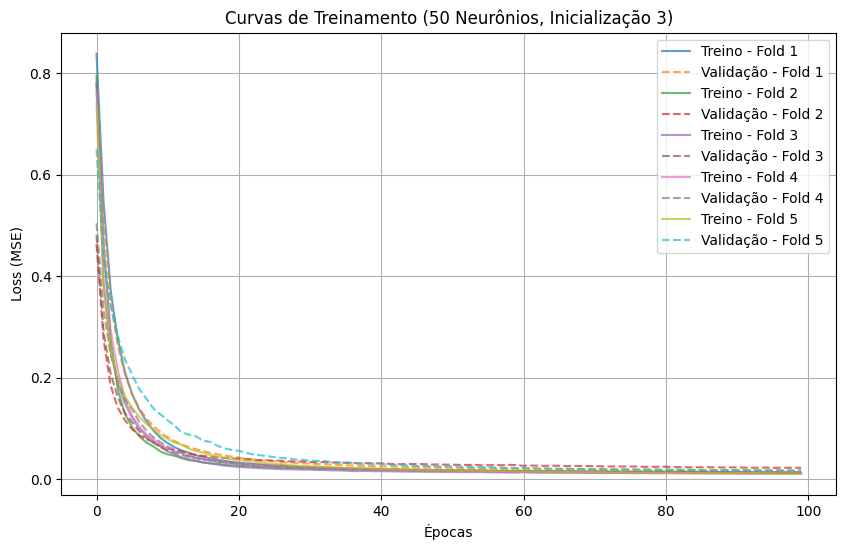

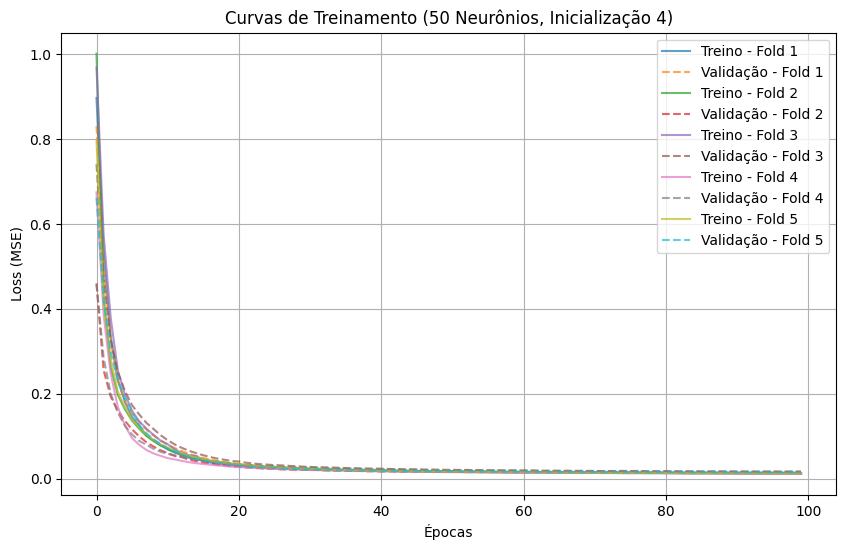

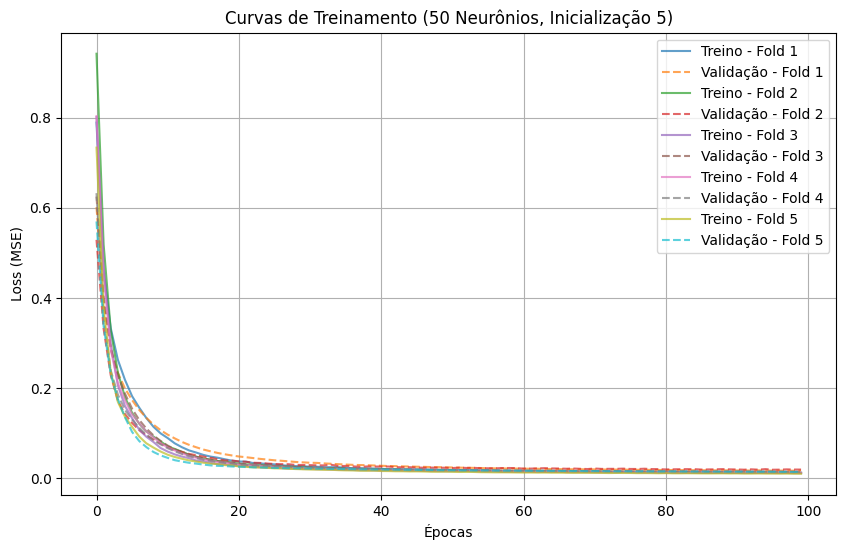

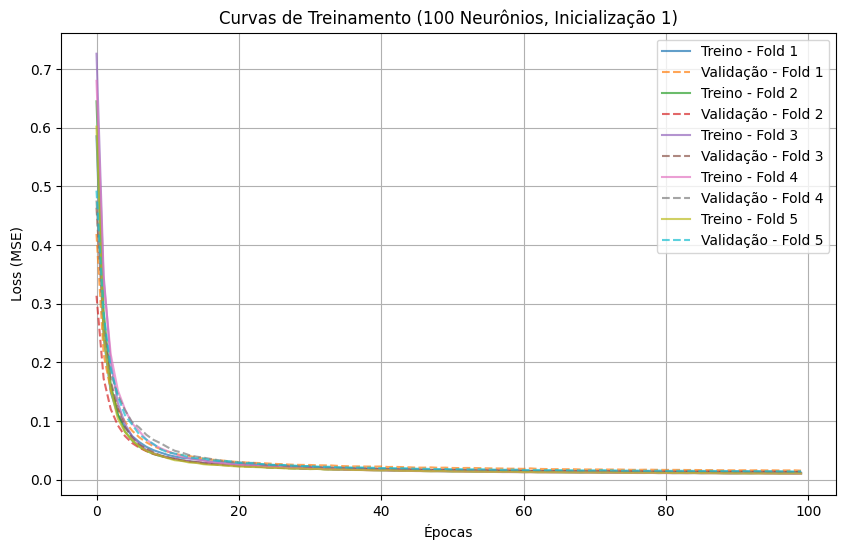

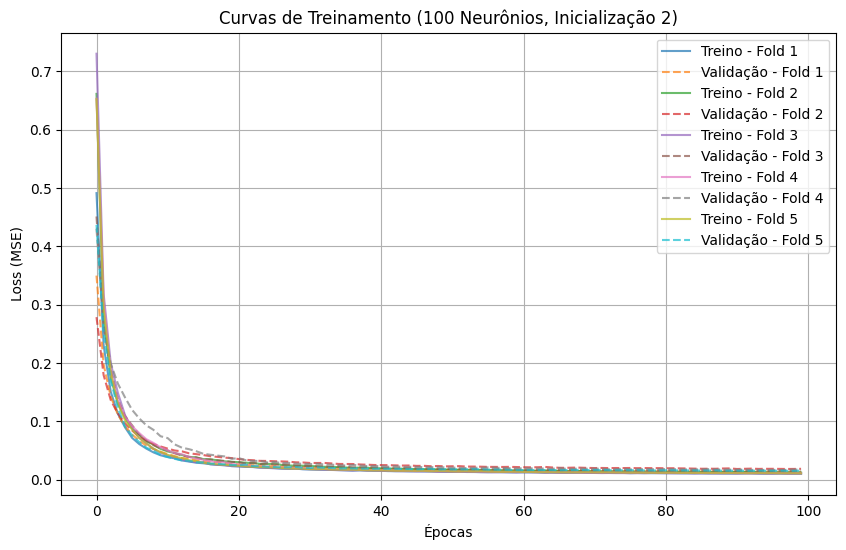

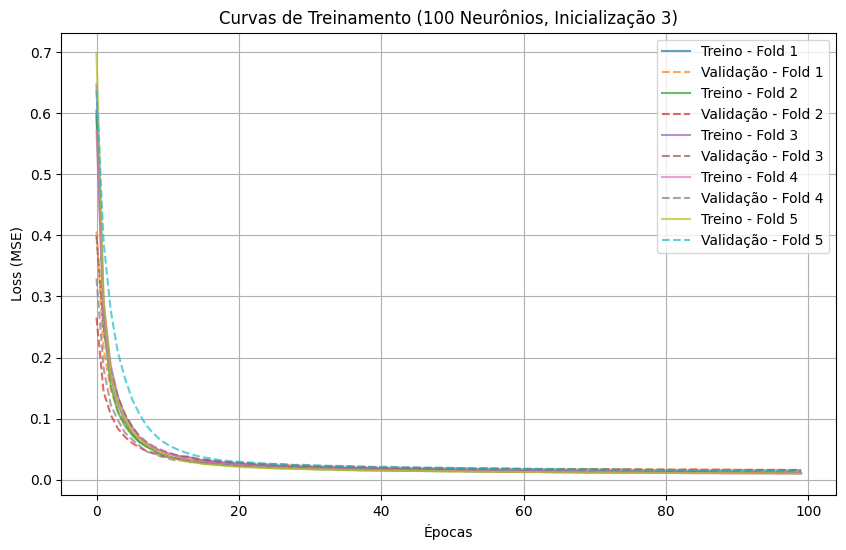

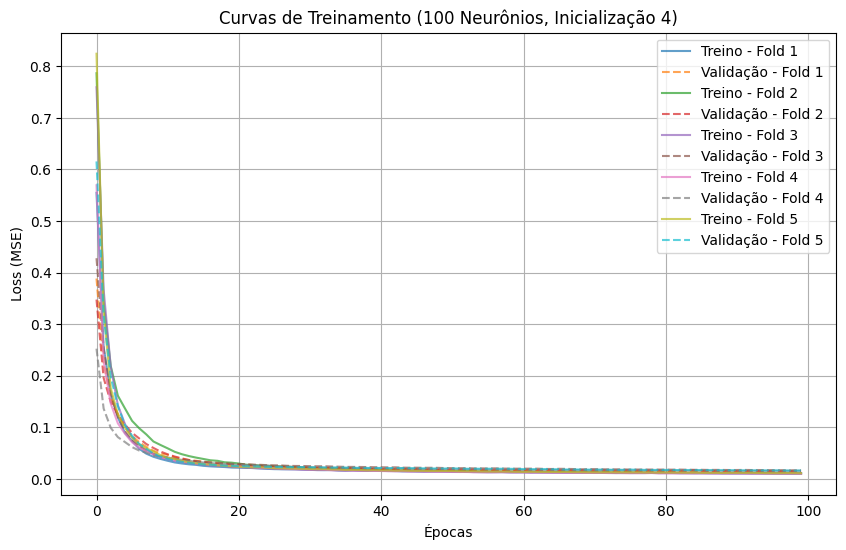

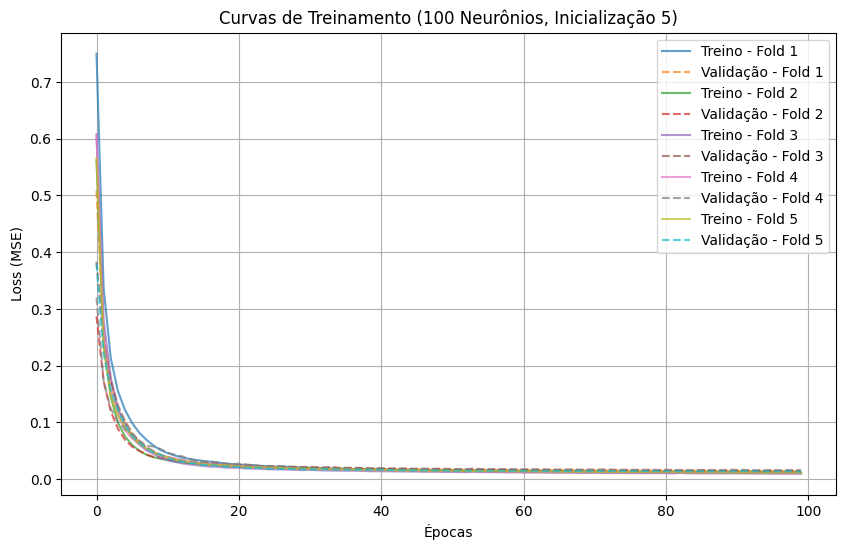

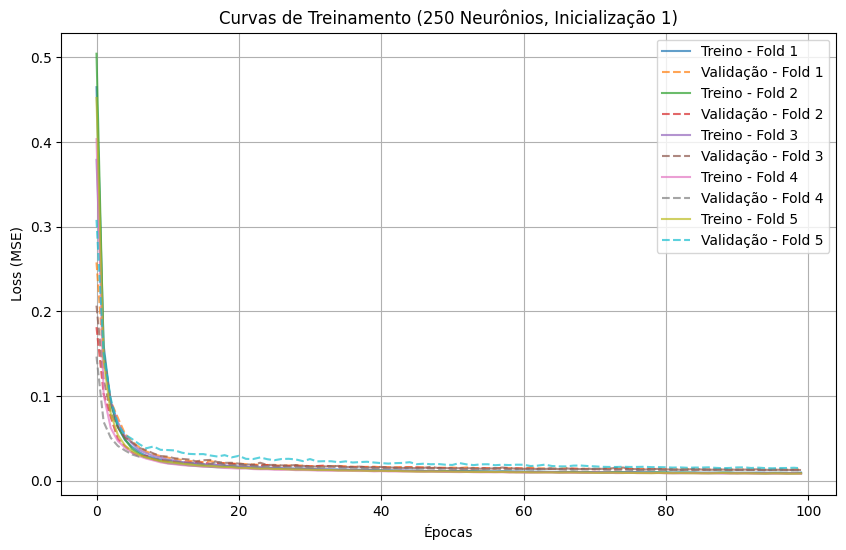

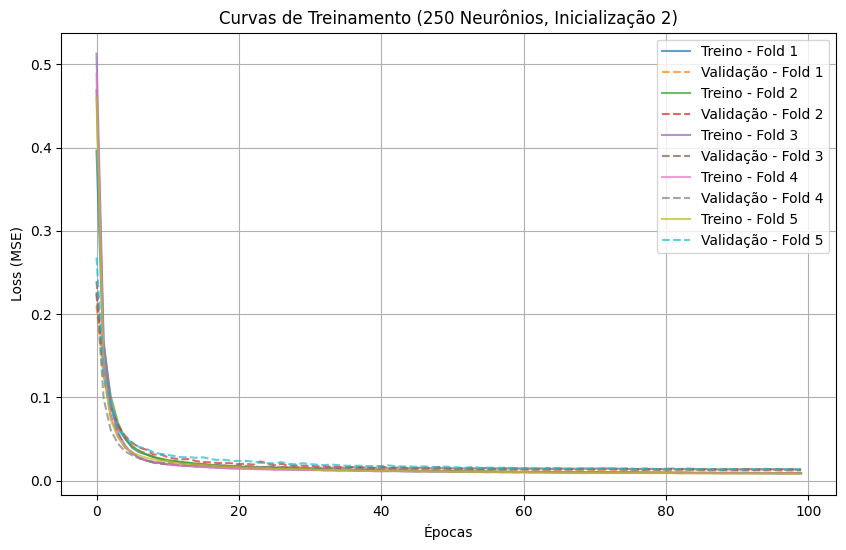

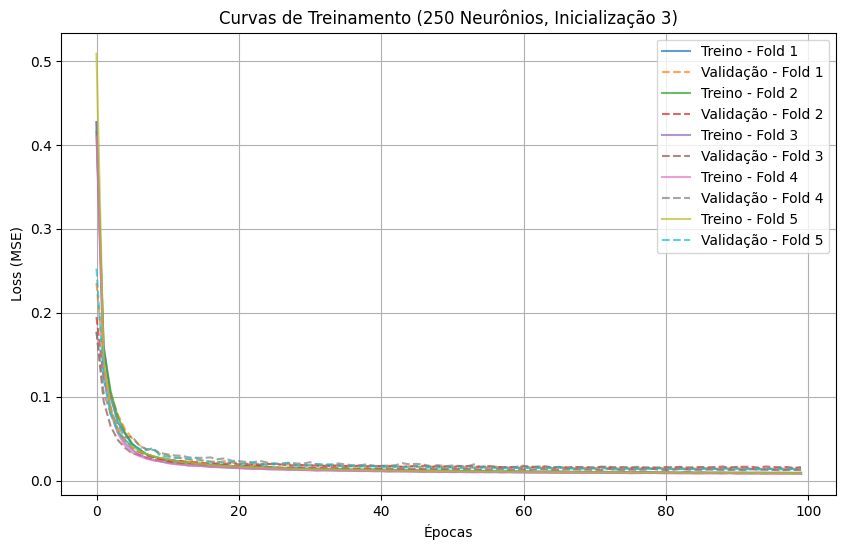

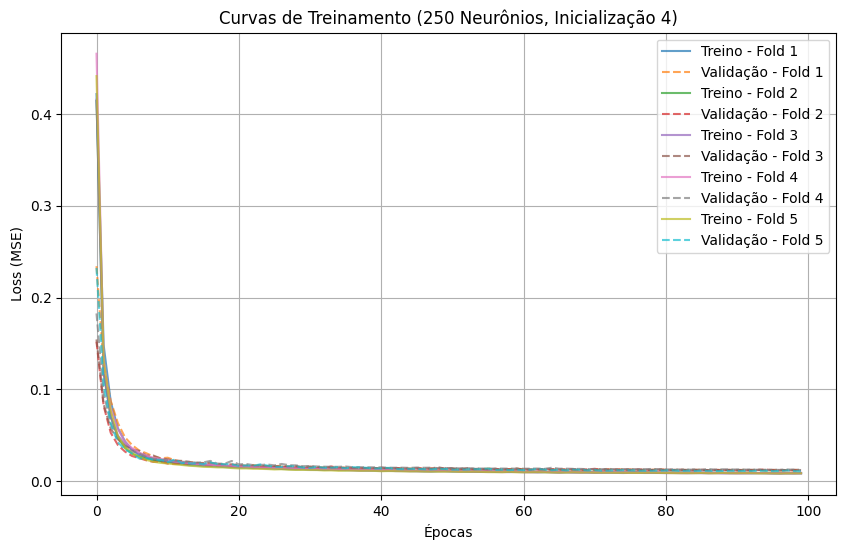

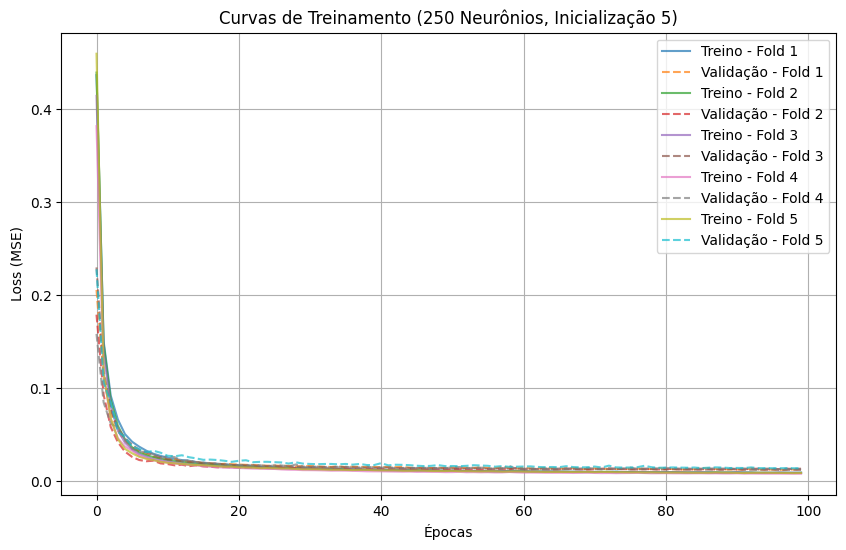

Neurônios: 10, MSE Médio: 0.0183, Desvio Padrão: 0.0023
Neurônios: 50, MSE Médio: 0.0163, Desvio Padrão: 0.0017
Neurônios: 100, MSE Médio: 0.0152, Desvio Padrão: 0.0013
Neurônios: 250, MSE Médio: 0.0133, Desvio Padrão: 0.0012


In [17]:
hidden_neurons_list = [10, 50, 100, 250]
results = train_with_kfold(X, y, hidden_neurons_list)

In [18]:
best_neurons = min(results, key=lambda x: x['mean_mse'])['hidden_neurons']
print(f"O melhor número de neurônios é: {best_neurons}")

O melhor número de neurônios é: 250


# Análise dos resultados



*  *Escolha do Padrão de Erro Utilizado*: Neste experimento, foi adotado o MSE (Mean Squared Error) como métrica principal para avaliar o desempenho do modelo durante o treinamento e a validação. O MSE foi escolhido por sua simplicidade e por refletir diretamente o erro médio ao prever os valores-alvo escalonados em tarefas de regressão
*  *Análise do Desempenho do Modelo*: O modelo utilizado é uma rede neural rasa com apenas uma camada oculta, que, devido à sua simplicidade estrutural, apresenta dificuldades para se adaptar a problemas mais complexos. Não foram observados sinais de overfitting, indicando que o modelo permaneceu relativamente bem generalizado dentro das configurações avaliadas.
*  Os resultados mostram que o erro do modelo para diferentes números de neurônios segue um comportamento exponencial inverso, ou seja, o aumento do número de neurônios reduz o erro, mas de forma decrescente e em menor proporção a partir de certo ponto.Além disso, aparentemente um maior número de neurônios tornou a diferença de magnitude entre a perda(MSE) menor entre diferentes folds.
*  *Possíveis Melhorias*:
1.   Utilizar um modelo com mais camadas escondidas,uma vez que tais camadas ajudam a capturar interações complexas entre características e padrões de alta abstração através de seu comportamento hierárquico.
2.   Aplicar um regularizador como Dropout também pode ser interessante para evitar overfitting,principalmente se for um modelo profundo.
3.   Testar diferentes hiperparâmetros e otimizadores visando melhor desempenho e comnbate ao Gradient Vanishing.Sugestões:Otimizador Adam,substituir as funções de ativação daas camadas internas de ReLU por ELU e aplicar normalização em batch.Não seria necessária buscar algum algoritmo para taxa de aprendizado,uma vez que o Adam já faz isso implicitamente.


*   *Conclusões: O experimento demonstrou que, embora uma rede neural rasa seja capaz de reduzir o erro progressivamente ao se aumentar o número de neurônios, os ganhos se tornam marginais além de um certo ponto. A arquitetura de uma única camada tem suas limitações em problemas mais complexos, e um modelo profundo seria mais adequado, permitindo que o aprendizado fosse distribuído em diferentes níveis de abstração.Portanto, para uma solução mais eficaz e escalável, recomenda-se a utilização de redes neurais profundas com regularização adequada, otimizadores modernos e ajustes finos de hiperparâmetros. Essas melhorias podem não apenas reduzir o erro, mas também torná-lo mais robusto em relação a novos dados.


# Treinamento do modelo com número de neurônios que obtiveram melhor avaliação e aplicando diferentes learning rates e batch sizes

In [19]:
def hyperparameter_optimization(X, y, best_neurons, batch_sizes, learning_rates, epochs=200, k=5):
    """
    Refinar treinamento ajustando batch_size e learning_rate para a melhor configuração de neurônios.
    """
    refined_results = []
    criterion = nn.MSELoss()

    # Converter X e y para tensores PyTorch
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y)
    dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)

    for batch_size in batch_sizes:
        for learning_rate in learning_rates:
            kf = KFold(n_splits=k, shuffle=True, random_state=42)
            history_losses = {'train_loss': [], 'val_loss': []}

            for train_idx, val_idx in kf.split(X):
                # Dividir os dados do fold
                train_data = torch.utils.data.Subset(dataset, train_idx)
                val_data = torch.utils.data.Subset(dataset, val_idx)

                train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
                val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

                # Criar o modelo
                model = MLP(X.shape[1], best_neurons)
                optimizer = optim.Adam(model.parameters(), lr=learning_rate)

                train_losses = []
                val_losses = []

                for epoch in range(epochs):
                    # Treinamento
                    model.train()
                    train_loss_epoch = 0
                    for X_batch, y_batch in train_loader:
                        optimizer.zero_grad()
                        y_pred = model(X_batch)
                        loss = criterion(y_pred, y_batch.view(-1, 1))
                        if not torch.isfinite(loss):
                            print(f"Loss inválida detectada no treinamento. Encerrando.")
                            break
                        loss.backward()
                        optimizer.step()
                        train_loss_epoch += loss.item()
                    train_losses.append(train_loss_epoch / len(train_loader))

                    # Validação
                    model.eval()
                    val_loss_epoch = 0
                    with torch.no_grad():
                        for X_batch, y_batch in val_loader:
                            y_pred = model(X_batch)
                            loss = criterion(y_pred, y_batch.view(-1, 1))
                            if not torch.isfinite(loss):
                                print(f"Loss inválida detectada na validação. Encerrando.")
                                break
                            val_loss_epoch += loss.item()
                    val_losses.append(val_loss_epoch / len(val_loader))

                # Salvar histórico de perdas
                history_losses['train_loss'].append(train_losses)
                history_losses['val_loss'].append(val_losses)

            # Calcular MSE e Overfitting Relativo
            avg_train_loss = np.mean(history_losses['train_loss'], axis=0)
            avg_val_loss = np.mean(history_losses['val_loss'], axis=0)

            mse = avg_val_loss[-1] if np.isfinite(avg_val_loss[-1]) else np.nan
            relative_overfit = np.mean((avg_val_loss - avg_train_loss) / avg_train_loss) if np.isfinite(avg_val_loss).all() else np.nan

            # Ignorar configurações inválidas
            if not np.isfinite(mse) or not np.isfinite(relative_overfit):
                print(f"Configuração ignorada: Batch Size={batch_size}, Learning Rate={learning_rate}.")
                continue

            # Guardar resultados
            refined_results.append({
                'batch_size': batch_size,
                'learning_rate': learning_rate,
                'mse': mse,
                'relative_overfit': relative_overfit
            })

            # Gerar curva média de loss
            plt.figure(figsize=(12, 6))
            plt.plot(avg_train_loss, label="Treino (Média)")
            plt.plot(avg_val_loss, label="Validação (Média)", linestyle='dashed')
            plt.title(f"Curvas de Treinamento (Batch Size {batch_size}, Learning Rate {learning_rate})")
            plt.xlabel("Épocas")
            plt.ylabel("Loss (MSE)")
            plt.legend()
            plt.grid()
            plt.show()

    # Exibir resultados
    for res in refined_results:
        print(f"Batch Size: {res['batch_size']}, Learning Rate: {res['learning_rate']}, "
              f"MSE: {res['mse']:.4f}, Overfitting Relativo: {res['relative_overfit']:.4f}")
    return refined_results


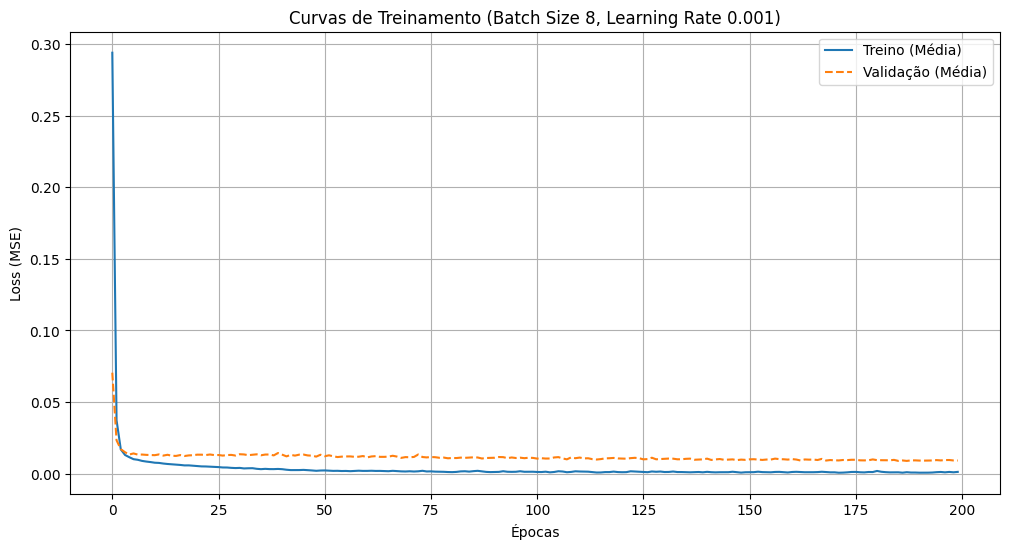

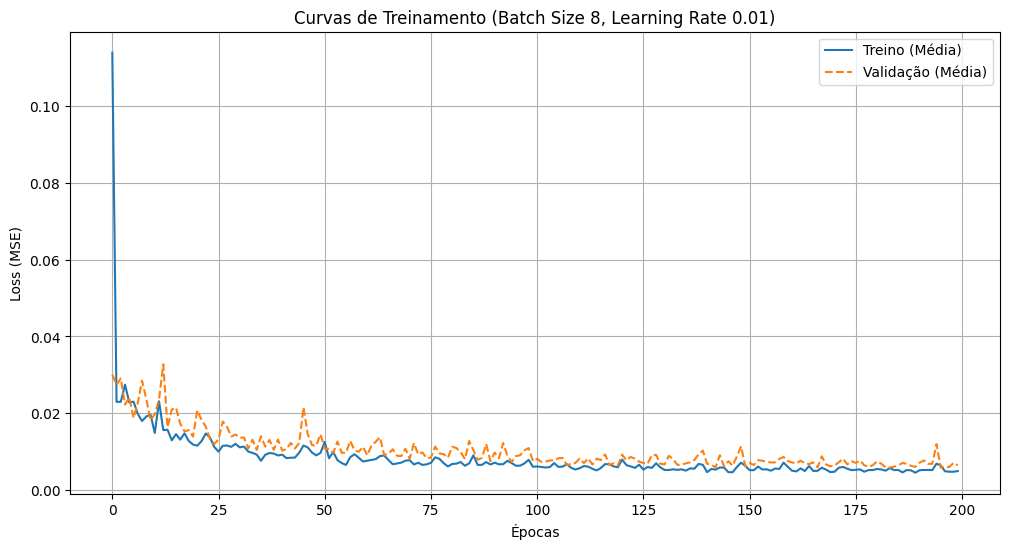

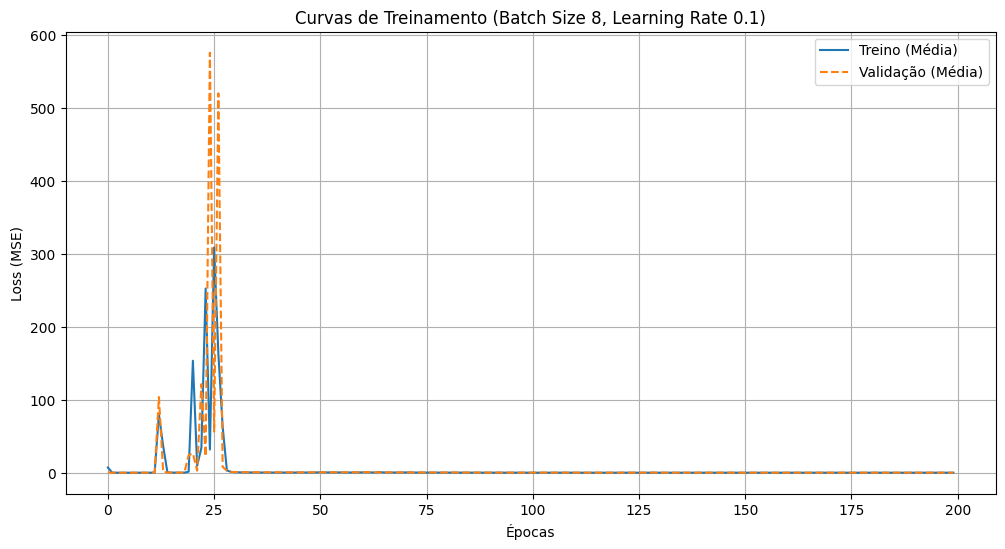

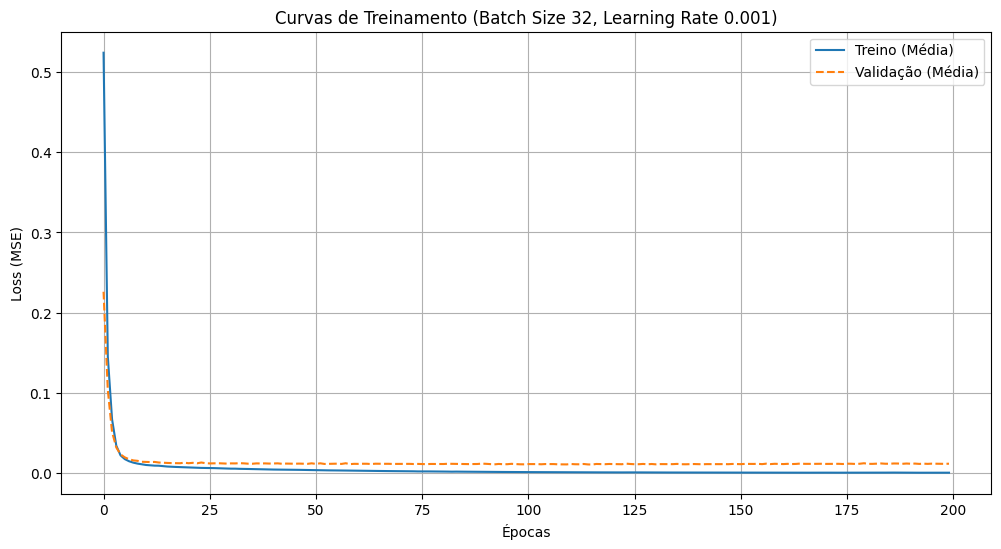

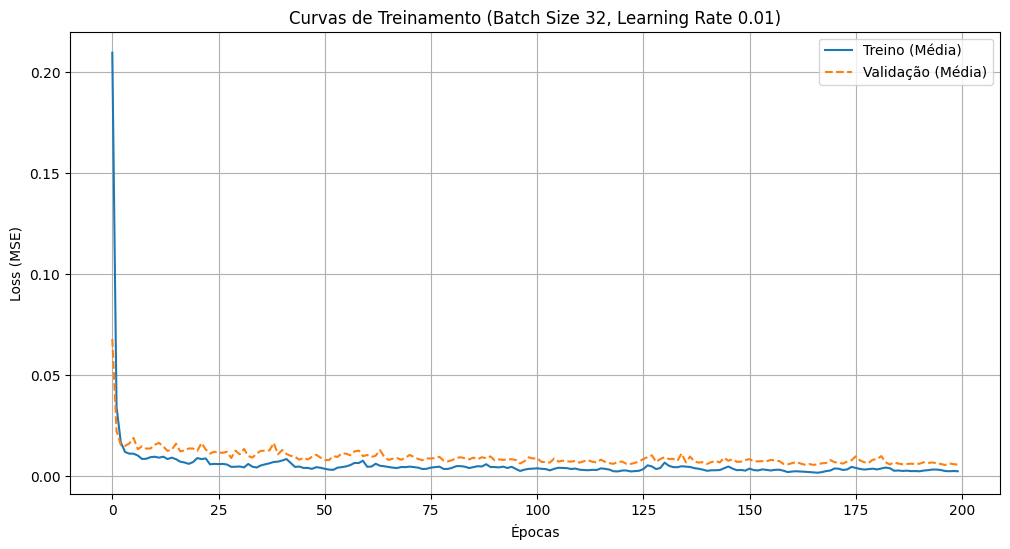

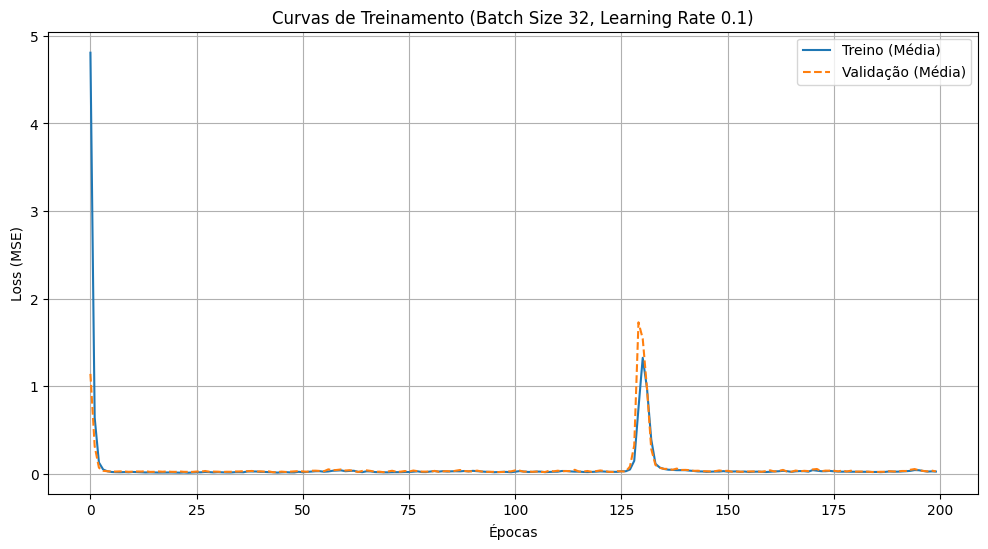

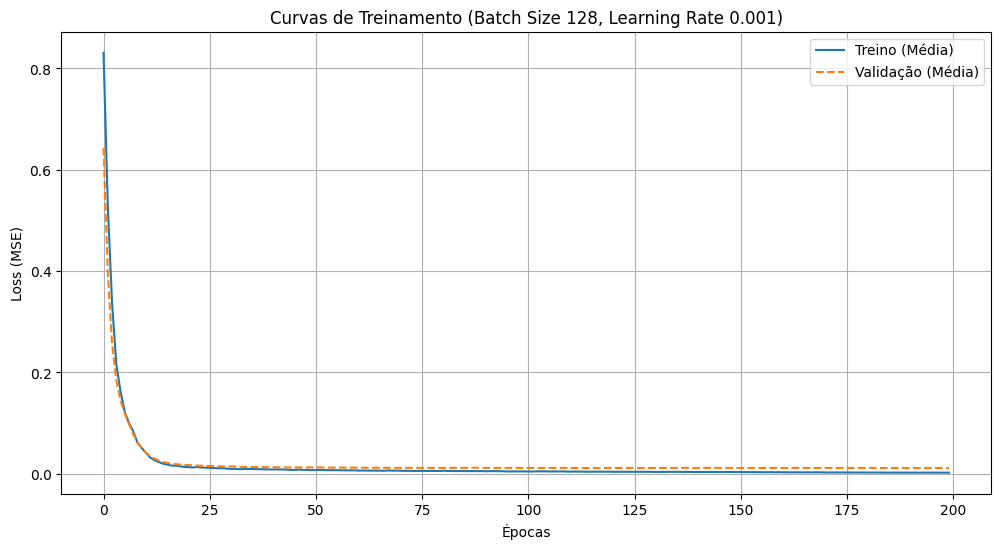

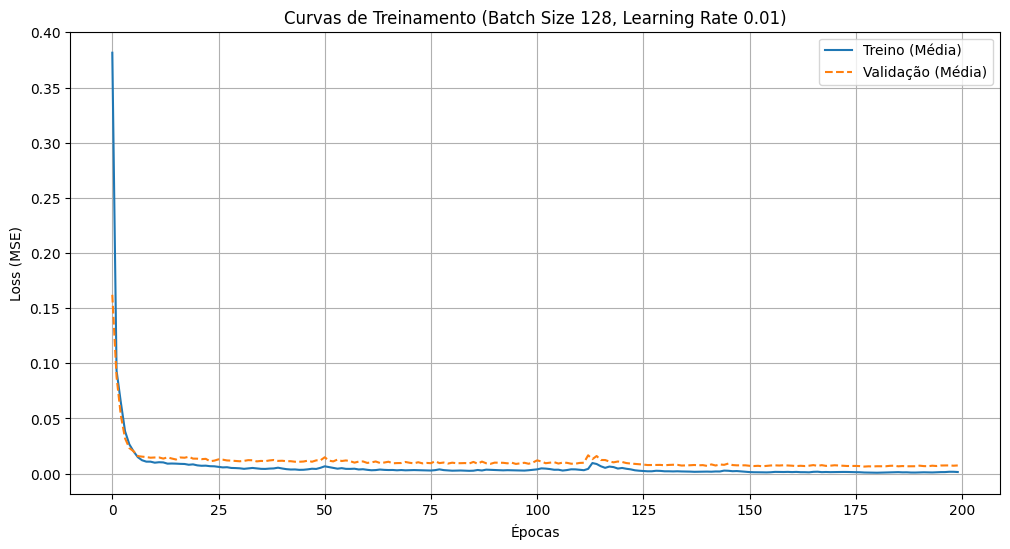

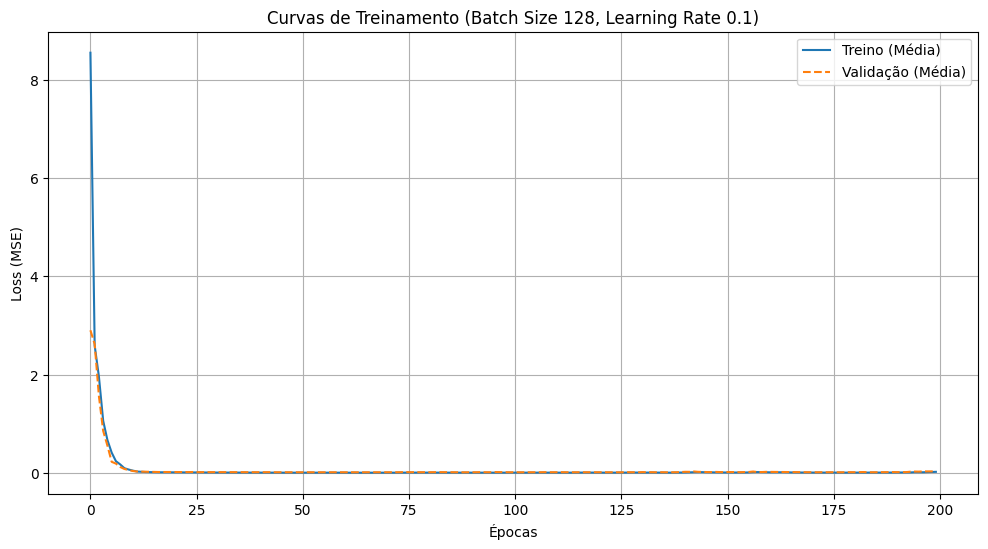

Batch Size: 8, Learning Rate: 0.001, MSE: 0.0091, Overfitting Relativo: 6.7410
Batch Size: 8, Learning Rate: 0.01, MSE: 0.0065, Overfitting Relativo: 0.3109
Batch Size: 8, Learning Rate: 0.1, MSE: 0.1196, Overfitting Relativo: 0.8847
Batch Size: 32, Learning Rate: 0.001, MSE: 0.0114, Overfitting Relativo: 19.5295
Batch Size: 32, Learning Rate: 0.01, MSE: 0.0056, Overfitting Relativo: 1.1622
Batch Size: 32, Learning Rate: 0.1, MSE: 0.0245, Overfitting Relativo: 0.2740
Batch Size: 128, Learning Rate: 0.001, MSE: 0.0111, Overfitting Relativo: 1.7361
Batch Size: 128, Learning Rate: 0.01, MSE: 0.0074, Overfitting Relativo: 2.5214
Batch Size: 128, Learning Rate: 0.1, MSE: 0.0310, Overfitting Relativo: 1.3977


In [20]:
batch_sizes = [8, 32, 128]
learning_rates = [0.001, 0.01,0.1]

refined_results = hyperparameter_optimization(X, y, best_neurons, batch_sizes, learning_rates)

In [21]:
best_config = min(refined_results, key=lambda x: x['mse'])

best_batch_size = best_config['batch_size']
best_learning_rate = best_config['learning_rate']

print(f"Melhor Configuração Encontrada:")
print(f"Batch Size: {best_batch_size}, Learning Rate: {best_learning_rate}, MSE: {best_config['mse']:.4f}")

Melhor Configuração Encontrada:
Batch Size: 32, Learning Rate: 0.01, MSE: 0.0056


# Análise dos Resultados


  Os resultados demonstram que o desempenho do modelo é altamente sensível à combinação de tamanho do batch e taxa de aprendizado (learning rate), refletindo as limitações de uma arquitetura pouco complexa. Além disso, o número limitado de épocas pode ter contribuído para restringir a convergência ideal em algumas configurações.


1.   *Batch Menores* : Apresentaram melhores resultados em termos de MSE com taxas de aprendizado menores.
*     Isso é esperado, já que tamanhos menores de batch introduzem maior variabilidade estocástica nas atualizações de gradiente, o que pode ajudar o modelo a escapar de mínimos locais.
*     No entanto, quando combinados com taxas de aprendizado maiores,a curva de perda tornou-se instável devido a oscilações excessivas nas atualizações.
2.   *Batch Intermediários* : Essa configuração proporcionou um equilíbrio ideal entre estabilidade e desempenho.
*   A combinação de batch_size=32 e learning_rate=0.01 foi a mais eficiente, alcançando MSE baixo e overfitting moderado.
*    Taxas de aprendizado altas (0.1) foram mais gerenciáveis aqui do que com batches pequenos
3.  *Tamanhos de batch maiores* : Apresentaram um desempenho significativamente pior em termos de MSE com taxas de aprendizado baixas (e.g., 0.001).
*   Isso ocorre porque batches maiores suavizam excessivamente as atualizações do gradiente, reduzindo a capacidade do modelo de capturar nuances nos dados.
*   Com taxas de aprendizado moderadas (0.01), o desempenho foi mais equilibrado, embora ainda inferior ao obtido com batches intermediários. Taxas de aprendizado altas (0.1) resultaram em curvas de perda estáveis, mas com maior overfitting.

Conclusão :
*   Batch intermediários (32) e taxas de aprendizado moderadas (0.01) demonstraram o melhor equilíbrio entre estabilidade, generalização e desempenho. Essa configuração combina os benefícios de estabilidade e variabilidade controlada no gradiente.
*  Altas learning rates tendem a ser altamente instáveis com batches pequenos, mas tornam-se mais estáveis com batches grandes.
*   Baixas learning rates fornecem maior estabilidade nas curvas de perda, mas podem limitar a capacidade de aprendizado do modelo, especialmente com batches maiores.






# Treinamento com diferentes otimizadores


Definição dos Otimizadores utilizados

In [22]:
class LevenbergMarquardt:
    def __init__(self, lambda_init=0.01):
        self.lambda_param = lambda_init  # Fator de regularização inicial

    def step(self, loss, model):
        # Calcula os gradientes
        gradients = torch.autograd.grad(loss, model.parameters(), create_graph=True)

        for param, grad in zip(model.parameters(), gradients):
            # Achata os gradientes para formato vetorial
            grad_flat = grad.view(-1, 1)  # [N, 1]

            # Construção aproximada da Hessiana
            try:
                H_approx = grad_flat @ grad_flat.T  # Jacobiana-Hessiana
                reg_term = self.lambda_param * torch.eye(H_approx.size(0), device=H_approx.device)
                H_approx += reg_term  # Adiciona regularização para estabilidade
            except RuntimeError as e:
                raise ValueError(f"Erro na construção da Hessiana aproximada: {e}")

            # Resolve o sistema linear Hx = -grad para o passo
            try:
                step = torch.linalg.solve(H_approx, -grad_flat).view(param.shape)
            except RuntimeError as e:
                raise ValueError(f"Erro na resolução do sistema linear: {e}")

            # Atualiza os parâmetros do modelo
            with torch.no_grad():  # Evita rastreamento do gradiente durante a atualização
                param.add_(step)  # Atualiza os pesos do modelo

In [23]:
class RPROP:
    def __init__(self, model, lr_init=0.1, delta_max=50, delta_min=1e-6):
        self.lr = {param: torch.full_like(param, lr_init) for param in model.parameters()}
        self.delta_max = delta_max
        self.delta_min = delta_min
        self.prev_grad = {param: torch.zeros_like(param) for param in model.parameters()}

    def step(self, model):
        for param in model.parameters():
            grad = param.grad
            update = grad * self.prev_grad[param]

            # Atualiza learning rate
            self.lr[param] = torch.clamp(
                self.lr[param] * torch.where(update > 0, 1.2, 0.5),
                min=self.delta_min,
                max=self.delta_max
            )

            # Atualiza parâmetros
            param.data -= torch.sign(grad) * self.lr[param]

            # Armazena o gradiente atual para uso no próximo passo
            self.prev_grad[param] = grad.clone()


Definição do Treinamento

In [24]:
def train_model(optimizer_name, model_class, X, y, batch_size=32, learning_rate=0.01, epochs=50, test_size=0.2):
    """
    Treina o modelo em um conjunto fixo de treino e validação.
    """
    # Divisão dos dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True)

    # Preparar dataloaders
    train_loader = prepare_data(X_train, y_train, batch_size)
    test_loader = prepare_data(X_test, y_test, batch_size)

    # Inicializar modelo
    model = model_class()

    # Inicializar critério e otimizador
    criterion = nn.MSELoss()
    if optimizer_name == "LM":
        optimizer = LevenbergMarquardt()
    elif optimizer_name == "RPROP":
        optimizer = RPROP(model, lr_init=learning_rate)
    else:
        raise ValueError("Otimização inválida: escolha 'LM' ou 'RPROP'.")

    train_losses = []
    test_losses = []

    # Treinamento
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            if optimizer_name == "LM":
                optimizer.step(loss, model)
            elif optimizer_name == "RPROP":
                loss.backward()
                optimizer.step(model)
                model.zero_grad()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        # Validação no conjunto de teste
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                y_pred = model(X_batch)
                test_loss += criterion(y_pred, y_batch).item()
        test_losses.append(test_loss / len(test_loader))

        print(f"Época {epoch + 1}/{epochs}, Loss Treino: {train_losses[-1]:.4f}, Loss Teste: {test_losses[-1]:.4f}")

    print(f"\nMSE final no conjunto de teste: {test_losses[-1]:.4f}")
    return train_losses, test_losses, test_losses[-1]

# Função para preparar os dados
def prepare_data(X, y, batch_size=32):
    dataset = TensorDataset(torch.FloatTensor(X), torch.FloatTensor(y))
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


Configurações Utilizadas com base nos resultados anteriores

In [25]:
input_dim = X_train_tensor.shape[1]
hidden_neurons = best_neurons
batch_size = best_batch_size
learning_rate = best_learning_rate
epochs = 50


In [26]:
# Treinamento com LM
train_losses_lm, test_losses_lm, mse_lm = train_model(
    optimizer_name="LM",
    model_class=lambda: MLP(input_dim, hidden_neurons),
    X=X_train_tensor.numpy(),
    y=y_train_tensor.numpy(),
    batch_size=batch_size,
    learning_rate=learning_rate,
    epochs=epochs,
)

# Treinamento com RPROP
train_losses_rprop, test_losses_rprop, mse_rprop = train_model(
    optimizer_name="RPROP",
    model_class=lambda: MLP(input_dim, hidden_neurons),
    X=X_train_tensor.numpy(),
    y=y_train_tensor.numpy(),
    batch_size=batch_size,
    learning_rate=learning_rate,
    epochs=epochs,
)


Época 1/50, Loss Treino: 10.1221, Loss Teste: 32.8582
Época 2/50, Loss Treino: 10.6118, Loss Teste: 18.8373
Época 3/50, Loss Treino: 5.2193, Loss Teste: 3.2359
Época 4/50, Loss Treino: 60.0686, Loss Teste: 56.6517
Época 5/50, Loss Treino: 27.5065, Loss Teste: 0.2872
Época 6/50, Loss Treino: 4.8349, Loss Teste: 0.9425
Época 7/50, Loss Treino: 8.4584, Loss Teste: 38.3371
Época 8/50, Loss Treino: 13.2835, Loss Teste: 9.9013
Época 9/50, Loss Treino: 17.5746, Loss Teste: 11.7511
Época 10/50, Loss Treino: 20.4668, Loss Teste: 14.0691
Época 11/50, Loss Treino: 36.3758, Loss Teste: 65.0749
Época 12/50, Loss Treino: 37.6355, Loss Teste: 5.8810
Época 13/50, Loss Treino: 17.9489, Loss Teste: 21.1659
Época 14/50, Loss Treino: 9.0335, Loss Teste: 16.4348
Época 15/50, Loss Treino: 18.2476, Loss Teste: 7.8955
Época 16/50, Loss Treino: 14.1222, Loss Teste: 23.3972
Época 17/50, Loss Treino: 26.7478, Loss Teste: 46.5399
Época 18/50, Loss Treino: 18.5113, Loss Teste: 9.2126
Época 19/50, Loss Treino: 29.8

Visualização dos Resultados

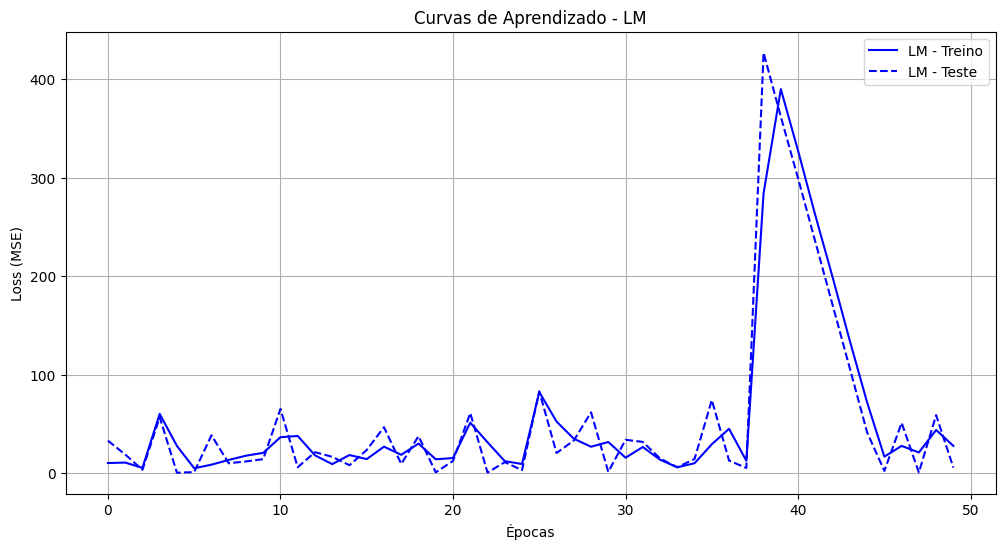

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(train_losses_lm, label="LM - Treino", linestyle="solid", color="blue")
plt.plot(test_losses_lm, label="LM - Teste", linestyle="dashed", color="blue")
plt.title("Curvas de Aprendizado - LM")
plt.xlabel("Épocas")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid()

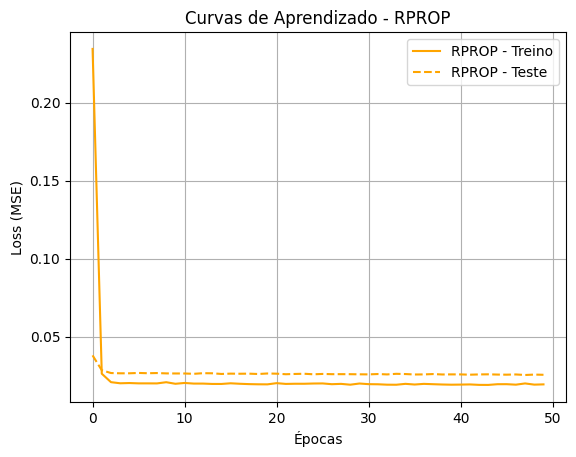

In [28]:
plt.plot(train_losses_rprop, label="RPROP - Treino", linestyle="solid", color="orange")
plt.plot(test_losses_rprop, label="RPROP - Teste", linestyle="dashed", color="orange")
plt.title("Curvas de Aprendizado - RPROP")
plt.xlabel("Épocas")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid()

MSE Final - Levenberg-Marquardt: 5.4313
MSE Final - RPROP: 0.0255


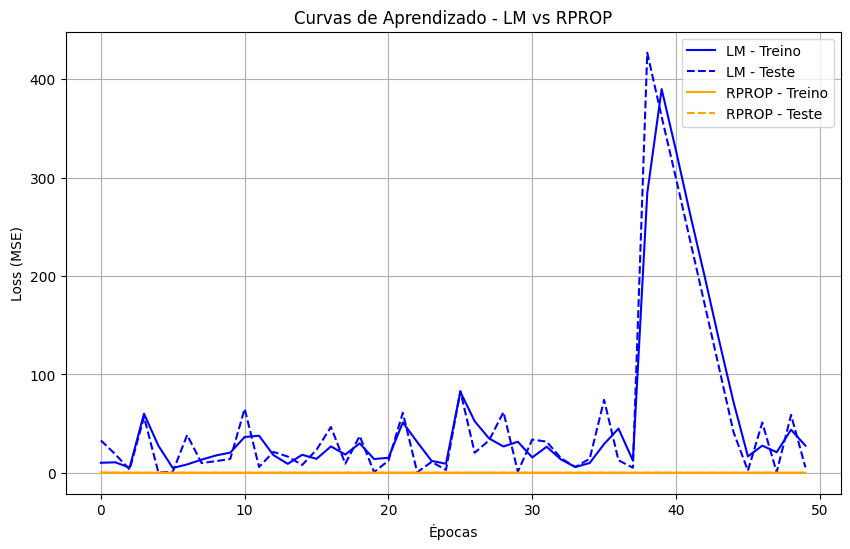

In [29]:
# Resultados
print(f"MSE Final - Levenberg-Marquardt: {mse_lm:.4f}")
print(f"MSE Final - RPROP: {mse_rprop:.4f}")

# Visualização das curvas
plt.figure(figsize=(10, 6))

# Curvas para LM
plt.plot(train_losses_lm, label="LM - Treino", linestyle="solid", color="blue")
plt.plot(test_losses_lm, label="LM - Teste", linestyle="dashed", color="blue")

# Curvas para RPROP
plt.plot(train_losses_rprop, label="RPROP - Treino", linestyle="solid", color="orange")
plt.plot(test_losses_rprop, label="RPROP - Teste", linestyle="dashed", color="orange")

plt.title("Curvas de Aprendizado - LM vs RPROP")
plt.xlabel("Épocas")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid()
plt.show()


# Análise dos Resultados

1.    *Levenberg-Marquardt (LM)*:
    * O algoritmo LM apresentou oscilações significativas tanto no conjunto de treino quanto no de teste.
    * Apesar de atingir bons valores de erro em alguns momentos, os picos abruptos indicam uma falta de estabilidade no processo de aprendizado.so pode estar associado à configuração do parâmetro lambda ou à implementação da aproximação da Hessiana.
    * Não foi observado um bom alinhamento entre os erros de treino e teste, indicando que o modelo pode não estar generalizando bem para novos dados.
2.  *Resilient Backpropagation (RPROP)*:
*       O algoritmo RPROP apresentou curvas extremamente estáveis tanto no conjunto de treino quanto no de teste, como mostrado no gráfico atual. Após uma queda inicial acentuada do erro, as curvas convergem rapidamente para um erro consistente e baixo.
*      A curva de treino atinge rapidamente um erro próximo a 0,02, enquanto a curva de teste acompanha esse comportamento com valores muito similares. Isso indica que o modelo foi bem ajustado e generaliza adequadamente.
*      O RPROP não apenas convergiu de forma eficiente, mas também apresentou excelente generalização, sendo extremamente adequado para o problema.
3.  *Conclusão*:
*    Com base na análise dos gráficos e do comportamento dos dois algoritmos, o RPROP é a escolha clara para o problema em questão.